In [20]:
import numpy as np
import torch
import os
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score

def Linear(in_features, out_features, bias=True):

    m = nn.Linear(in_features, out_features, bias)
    nn.init.xavier_uniform_(m.weight)
    if bias:
        nn.init.constant_(m.bias, 0.0)
    return m

class myDataset(Dataset):
    def __init__(self,node_features,adj_features):
        self.node_features = node_features
        self.adj_features = adj_features
        self.max_size = self.node_features.shape[1]
        self.node_dim = self.node_features.shape[2]
        self.edge_dim = self.adj_features.shape[1]
        self.n_samples = self.node_features.shape[0]
    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        X = self.node_features[idx]
        adj = self.adj_features[idx]

        return torch.Tensor(X), torch.Tensor(adj)
    

In [2]:
#Single GCN Layer for Autoencoder
class GCN_layer(nn.Module):
    """
    Relation GCN layer. 
    """

    def __init__(self, in_features, out_features, edge_dim=3, aggregate='sum', dropout=0.0, use_relu=True, bias=False):
        '''
        parameters:
        in/out_features: embedding dimension of input/output
        edge_dim: dim of edge type
        aggregate: Type of aggregation to be used for pooling
        '''
        super(GCN_layer, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.edge_dim = edge_dim
        self.dropout = dropout
        self.aggregate = aggregate
        if use_relu:
            self.act = nn.ReLU()
        else:
            self.act = None

        self.weight = nn.Parameter(torch.FloatTensor(
            self.edge_dim, self.in_features, self.out_features)) 
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(
                self.edge_dim, self.out_features)) 
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, x, adj):
        '''
        parameters:
        x: (batch, N, NODE_FEATURES)
        adj: (batch, EDGE_FEATURES, N, N)
        
        returns:
        embedding with shape (batch, N, d)
        '''
        
        x = F.dropout(x, p=self.dropout, training=self.training)  # (batch, N, d)

        batch_size = x.size(0)

        #form layer output
        support = torch.einsum('bnd, edh-> benh', x, self.weight)
        output = torch.einsum('...ij, ...jh-> ...ih', adj, support)  # (batch, EDGE_FEATURES, N, d)

        if self.bias is not None:
            output += self.bias
        if self.act is not None:
            output = self.act(output)  # (batch, EDGE_FEATURES, N, d)
        output = output.view(batch_size, self.edge_dim, x.size( 
            1), self.out_features)  # (batch, EDGE_FEATURES, N, d) 

        #Aggregates over each of the edge dimensions
        if self.aggregate == 'sum':
            # sum pooling #(batch, N, d)
            node_embedding = torch.sum(output, dim=1, keepdim=False)
        elif self.aggregate == 'max':
            # max pooling  #(batch, N, d)
            node_embedding = torch.max(output, dim=1, keepdim=False)
        elif self.aggregate == 'mean':
            # mean pooling #(batch, N, d)
            node_embedding = torch.mean(output, dim=1, keepdim=False)
        elif self.aggregate == 'none':
            node_embedding = output
        else:
            print('GCN aggregate error!')


        return node_embedding

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

In [3]:
#Autoencoder with GCN layers
class Autoencoder(nn.Module):
    def __init__(self, nfeat, nhid,nout=128,edge_dim =3, num_layers=5, dropout=0.0, normalization=False,gcn_bias=False):
        
        '''
        parameters:
        n_feat: number of node features
        n_hid: array of embedding sizes for each hidden layer
        n_out: embedding size for last layer
        '''
        super(Autoencoder, self).__init__()

        self.nfeat = nfeat
        self.nhid = nhid
        self.nout = nout
        self.edge_dim = edge_dim
        self.num_layers = num_layers

        self.dropout = dropout
        self.normalization = normalization

        self.emb = Linear(nfeat, nfeat, bias=False) 
        #self.bn_emb = nn.BatchNorm2d(8)

        self.gc1 = GCN_layer(
            nfeat, nhid[0], edge_dim=self.edge_dim, aggregate='sum', use_relu=True, dropout=self.dropout, bias = gcn_bias)
        if self.normalization:
            self.bn1 = nn.BatchNorm2d(nhid[0])

        self.gc2 = nn.ModuleList([GCN_layer(nhid[i], nhid[i+1], edge_dim=self.edge_dim, aggregate='sum',
                                                           use_relu=True, dropout=self.dropout, bias= gcn_bias)
                                  for i in range(self.num_layers-2)])
        if self.normalization:
            self.bn2 = nn.ModuleList([nn.BatchNorm2d(nhid[i+1]) for i in range(self.num_layers-2)])

        self.gc3 = GCN_layer(
            nhid[-1], nout, edge_dim=self.edge_dim, aggregate='none', use_relu=False, dropout=self.dropout, bias= gcn_bias)
        
        if self.normalization:
            self.bn3 = nn.BatchNorm2d(nout)
            
        self.activation = nn.Sigmoid()

    def forward(self, x, adj):
        '''
        :param x: (batch, N, d)
        :param adj: (batch, E, N, N)
        :return:
        '''
        # TODO: Add normalization for adacency matrix
        # embedding layer
        x = self.emb(x)
        #if self.normalization:
            #x = self.bn_emb(x.transpose(0, 3, 1, 2))
            #x = x.transpose(0, 2, 3, 1)

        # first GCN layer
        x = self.gc1(x, adj)
        #if self.normalization:
            #x = self.bn1(x.transpose(0, 3, 1, 2))
            #x = x.transpose(0, 2, 3, 1)

        # hidden GCN layer(s)
        for i in range(self.num_layers-2):
            x = self.gc2[i](x, adj)  # (#node, #class)
            #if self.normalization:
                #x = self.bn2[i](x.transpose(0, 3, 1, 2))
                #x = x.transpose(0, 2, 3, 1)

        # last GCN layer
        x = self.gc3(x, adj)  # (batch, N, d)
        #if self.normalization:
            #x = self.bn3(x.transpose(0, 3, 1, 2))
            #x = x.transpose(0, 2, 3, 1)

        #Reconstructs the adjacency matrix as x * x^T
        xt = torch.transpose(x,2,3)
        A = torch.einsum('bend, bedj-> benj', x, xt)
        
        return self.activation(A)

In [22]:
def train_epoch(model,criterion,optimizer,train_loader,valid_loader,device):
    model.train()
    total_loss = 0.0
    
    for X,adj in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        adj = adj.to(device)
        pred = model(X,adj)
        loss = criterion(pred,adj)
        loss.backward()
        optimizer.step()
     
    model.eval()
    for X,adj in valid_loader:
        X = X.to(device)
        adj = adj.to(device)
        pred = model(X,adj)
        loss = criterion(pred,adj)
        total_loss += X.shape[0] * loss.item()
        
    return total_loss / len(valid_loader)

def read_data(folder,name):
    path = os.getcwd() + '/'  + folder + '/'
    node_features = np.load(path + name + '_node_features.npy')
    adj_features = np.load(path + name +  '_adj_features.npy')
    mol_sizes = np.load(path + name + '_sizes.npy')

    f = open(path + '_config.txt', 'r')
    data_config = eval(f.read())
    f.close()

    return node_features, adj_features, mol_sizes, data_config 

def find_distribution(data_loader,model,criterion,device):
    #Stores the probabilities of each graph
    losses = []
    for X,adj in data_loader:
        
        #Reads in the batch adjacency tensors and node feature matrices
        adj = adj.to(device)
        X = X.to(device)
        pred = model(X,adj)
        loss = criterion(pred,adj)
        losses.append(loss.item())
        
    return np.array(losses)
        

In [5]:
#Generate the samples
!python3.8 data_process.py Data 1000 10 100 100

Name: 
Type: Graph
Number of nodes: 7852
Number of edges: 8261
Average degree:   2.1042
Max dependency: 18
Training dataset node stats: mean - 2.29 std - 1.63, [2.00,20.00]
Training dataset degree stats: mean - 1.05 std - 0.17, [1.00,2.60]
Training dataset triangle stats: mean - 0.02 std - 0.22, [0.00,4.00]
Successfully generated 1000 graphs for training
Successfully generated 10 graphs for validation
Successfully generated 100 graphs for testing

Anomaly set node stats: mean - 16.24 std - 0.75
Anomaly set degree stats: mean - 15.66 std - 1.12
Anomaly set triangle stats: mean - 482.80 std - 38.93
Successfully generated 100 Anomalous graphs


In [6]:
#Reads in the data 
train_X, train_adj, train_sizes, data_config  = read_data('test_data','train')
valid_X, valid_adj, valid_sizes, data_config = read_data('test_data','valid')
test_X,test_adj,test_sizes,data_config = read_data('test_data','test')


train_set = myDataset(train_X,train_adj)
train_loader = DataLoader(dataset=train_set,batch_size=64,shuffle=True)

valid_set = myDataset(valid_X,valid_adj)
valid_loader = DataLoader(dataset=valid_set,batch_size=64,shuffle=True)

test_set = myDataset(test_X,test_adj)
test_loader = DataLoader(dataset=test_set,batch_size=64,shuffle=True)

node_dim = train_X.shape[2]
edge_dim = train_adj.shape[1]

nhid = [128,64,32,64]
model = Autoencoder(nfeat = node_dim,nhid=nhid, edge_dim = edge_dim,num_layers=5)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

criterion = nn.MSELoss()
#Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:

n_epochs = 10
total_loss = []
for epoch in range(n_epochs):
    loss = train_epoch(model,criterion,optimizer,train_loader,valid_loader,device)
    print('Epoch',epoch,'loss:',loss)
    total_loss.append(loss)


Epoch 0 loss: 2.5
Epoch 1 loss: 2.5
Epoch 2 loss: 2.5
Epoch 3 loss: 2.5
Epoch 4 loss: 2.5
Epoch 5 loss: 2.5
Epoch 6 loss: 2.5
Epoch 7 loss: 2.5
Epoch 8 loss: 2.5
Epoch 9 loss: 2.5


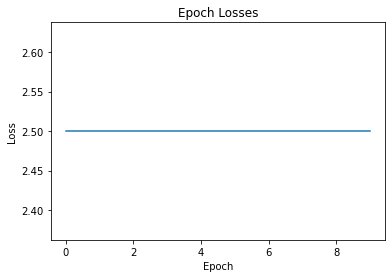

/Users/dylanwalker/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/dylanwalker/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Best Threshold=0.250000:
AUC score: 0.650
f1 score: 0.000
Precision@50: 0.000
Recall@50: 0.000
Precision@100: 0.000
Recall@100: 0.000
Precision: 0.000
Recall: 0.000


<Figure size 432x288 with 0 Axes>

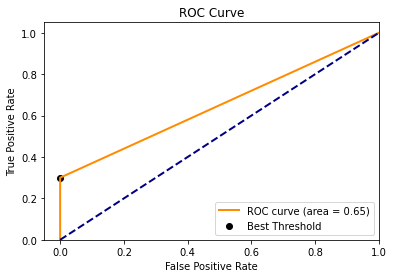

In [27]:
    #Creates a plot of the losses as a function of the epoch
    plt.plot(total_loss)
    plt.title("Epoch Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.savefig('epoch_losses.png')
    plt.show()
    plt.clf()

    
    model.eval()

    #Loads anomaly data
    anom_X,anom_adj,anom_sizes,data_config = read_data('test_data','extra')
    anom_set = myDataset(anom_X,anom_adj)
    anom_loader = DataLoader(dataset=anom_set,batch_size=10,shuffle=True)
        
    #Calculates the log-prob distribution for each set
    train_probs = find_distribution(train_loader,model,criterion,device)
    test_probs = find_distribution(test_loader,model,criterion,device)
    anom_probs = find_distribution(anom_loader,model,criterion,device)

    #Concatenates
    total_probs = np.concatenate((test_probs,anom_probs))


    #Plots histograms for each set with a kde plot overlay
    sns.histplot(data=train_probs,color='b',stat="density",label='Train', kde=True)
    sns.histplot(data=test_probs,color='g',stat="density",label='Test',kde=True)
    sns.histplot(data=anom_probs,color='r',stat="density",label='Anomalies',kde=True)
    plt.legend()
    plt.xlabel('Log-likelihood')
    plt.savefig('prob_distribution.png')
    plt.clf()

    # Forms ROC curve and calculates AUC score
    # Takes only the testing data and anomaly data (excludes training data)
    Y_probs = total_probs
    # Initializes class label 1 for all graphs from the test set and 0 for all graphs from the anomaly dataset
    Y_true = np.zeros(Y_probs.shape[0])
    Y_true[test_probs.shape[0]:] = 1
    #Calculates the ROC and AUC statistics
    fpr,tpr,thresholds = roc_curve(Y_true,-1 * Y_probs)
    roc_auc = auc(fpr,tpr)

    #Finds the optimal threshold
    geometric_means = np.sqrt(tpr * (1 - fpr))
    best_threshold_index = np.argmax(geometric_means)
    best_threshold = - thresholds[best_threshold_index]
    print('Best Threshold=%f:' % best_threshold)

    #Plots ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], marker='o', color='black', label='Best Threshold')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve.png')


    Y_pred = np.zeros(Y_true.shape[0])
    Y_pred[Y_probs < best_threshold] = 1
    f1 = f1_score(Y_true,Y_pred)

    print('AUC score: %.3f' % roc_auc)
    print('f1 score: %.3f' % f1)

    results = []
    for i in range(Y_probs.shape[0]):
        results.append((Y_probs[i],Y_true[i]))

    results.sort(key = lambda x: x[0])

    n_anomalies = anom_probs.shape[0]
    
    for k in [50,100]:
        n_detected = sum((pred < best_threshold) for (pred,__) in results[:k])
        n_correct = sum( (truth == 1 and pred < best_threshold)  for (pred,truth) in results[:k]) 
        k_precision = 0
        if n_detected != 0:
            k_precision = float(n_correct) / n_detected
        k_recall = float(n_correct) / n_anomalies
        print('Precision@{:.0f}: {:.3f}'.format(k,k_precision))
        print('Recall@{:.0f}: {:.3f}'.format(k,k_recall))

    detections = Y_true[Y_pred == 1]
    n_correct = detections[detections == 1].shape[0]
    precision = 0
    if detections.shape[0] != 0:
        precision = float(n_correct) / detections.shape[0]
    recall = float(n_correct) / n_anomalies
    print('Precision:', '%.3f' % precision)
    print('Recall:','%.3f' % recall)